In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import scipy
from ikrlib import *

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Reshape
from tensorflow.keras.utils import to_categorical

In [135]:
# paths to data directories
TRAIN_TARGET = '../data/target_train/'
TRAIN_NTARGET = '../data/non_target_train/'
TEST_TARGET = '../data/target_dev/'
TEST_NTARGET = '../data/non_target_dev/'

# data meant for classification
EVAL = '../../SUR_projekt2019-2020_eval/eval/'

In [136]:
# load target and non target voice data
train_t = list(wav16khz2mfcc(TRAIN_TARGET).values()) # target train data
train_n = list(wav16khz2mfcc(TRAIN_NTARGET).values()) # non-target train data

print('TEST DATA')
test_t = wav16khz2mfcc(TEST_TARGET) # target test data
test_n = wav16khz2mfcc(TEST_NTARGET) # non-target test data

print(train_t[0].shape)



Processing file:  ../data/target_train/m429_01_r08_i0_0.wav
Processing file:  ../data/target_train/m429_01_p04_i0_0.wav
Processing file:  ../data/target_train/m429_02_p05_i0_0.wav
Processing file:  ../data/target_train/m429_02_p02_i0_0.wav
Processing file:  ../data/target_train/m429_01_r09_i0_0.wav
Processing file:  ../data/target_train/m429_02_r09_i0_0.wav
Processing file:  ../data/target_train/m429_02_r08_i0_0.wav
Processing file:  ../data/target_train/m429_01_r06_i0_0.wav
Processing file:  ../data/target_train/m429_02_p03_i0_0.wav
Processing file:  ../data/target_train/m429_01_p01_i0_0.wav
Processing file:  ../data/target_train/m429_01_p02_i0_0.wav
Processing file:  ../data/target_train/m429_02_p01_i0_0.wav
Processing file:  ../data/target_train/m429_01_r07_i0_0.wav
Processing file:  ../data/target_train/m429_01_r10_i0_0.wav
Processing file:  ../data/target_train/m429_02_r10_i0_0.wav
Processing file:  ../data/target_train/m429_02_r07_i0_0.wav
Processing file:  ../data/target_train/m

Processing file:  ../data/non_target_train/m422_03_r08_i0_0.wav
Processing file:  ../data/non_target_train/f401_04_f19_i0_0.wav
Processing file:  ../data/non_target_train/m414_04_r08_i0_0.wav
Processing file:  ../data/non_target_train/m414_03_r08_i0_0.wav
Processing file:  ../data/non_target_train/f406_06_r08_i0_0.wav
Processing file:  ../data/non_target_train/f406_01_r08_i0_0.wav
Processing file:  ../data/non_target_train/m416_04_f19_i0_0.wav
Processing file:  ../data/non_target_train/m422_02_r08_i0_0.wav
Processing file:  ../data/non_target_train/f403_03_f19_i0_0.wav
Processing file:  ../data/non_target_train/m414_03_f19_i0_0.wav
Processing file:  ../data/non_target_train/f401_01_r08_i0_0.wav
Processing file:  ../data/non_target_train/f403_04_f19_i0_0.wav
Processing file:  ../data/non_target_train/f402_03_r08_i0_0.wav
Processing file:  ../data/non_target_train/m420_04_r08_i0_0.wav
Processing file:  ../data/non_target_train/f406_01_f19_i0_0.wav
TEST DATA
Processing file:  ../data/targ

In [185]:
# Some parameters for us to play with....
MEAN_SEGMENT_LEN = 10
INITIAL_CUTOFF = 100
MEAN_MULTIPLIER = 1
DEFAULT_MEAN = 40.0

# this function cuts up the array to chunks and lets us process these
def divide_chunks(l, n):
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n]

def remove_silence(record):
    # First cut off the first 190 frames of the recording
    record = record[INITIAL_CUTOFF:]
    # calculate the mean energy in order to remove silence
    mean_energy = np.mean(record[:][:,0])
    #variance = np.var(record[:][:,0]) # variance helps us check if the removed segment is really silence
    
    if mean_energy > DEFAULT_MEAN: mean_energy = DEFAULT_MEAN
    
    # now split the arrays into segments of length MEAN_SEGMENT_LEN
    # and compare the mean of these chunks to the overall mean
    new = []
    for seg in divide_chunks(record, MEAN_SEGMENT_LEN):
        #print(np.mean(seg[:][:,0]), mean_energy, mean_energy*MEAN_MULTIPLIER)
        
        if (np.mean(seg[:][:,0]) > mean_energy * MEAN_MULTIPLIER): #and
            #np.var(seg[:][:,0]) < variance):
            new.append(seg)
            
    return np.vstack(new)

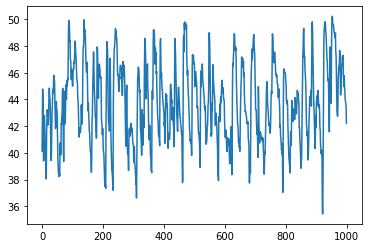

In [186]:
# Remove the silence from the training data
target = []
for rec in train_t:
    target.append(remove_silence(rec))

ntarget = []
for rec in train_n:
    ntarget.append(remove_silence(rec))
    
test_target = []
for rec in list(test_t.values()):
    test_target.append(remove_silence(rec))

test_ntarget = []
for rec in list(test_n.values()):
    test_ntarget.append(remove_silence(rec))

X_train_t = np.vstack(target)
X_train_n = np.vstack(ntarget)
X_test_t = np.vstack(test_target)
X_test_n = np.vstack(test_ntarget)

# After cutting the silence
plt.figure()
plt.plot(X_train_t[:1000][:,0])

In [187]:
SEGMENT_LEN = 50
STEP = 5

# this function creates "pictures" from our features by grouping them up
def create_frame_batches(data):
    # we need the speech sample to be at least as long as our batch length
    while data.shape[0] < SEGMENT_LEN:
        data += data
    
    grouped = []
    for i in range(0, data.shape[0] - SEGMENT_LEN, STEP):
        group = []
        for j in range(SEGMENT_LEN):
            group.append(data[i+j])
        grouped.append(np.vstack(group).flatten().reshape(SEGMENT_LEN, 13, 1))
    return np.array(grouped)

In [188]:
# Create 13x13 batches from the data
X_train_t = create_frame_batches(X_train_t)
X_train_n = create_frame_batches(X_train_n)
X_test_t = create_frame_batches(X_test_t)
X_test_n = create_frame_batches(X_test_n)

# Get all the data to one place
X_train = np.vstack((X_train_t, X_train_n))
y_train = np.hstack((np.zeros(X_train_t.shape[0]), np.ones(X_train_n.shape[0])))

X_test = np.vstack((X_test_t, X_test_n))
y_test = np.hstack((np.zeros(X_test_t.shape[0]), np.ones(X_test_n.shape[0])))

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

num_classes = 2

In [213]:
# convolutional
model = Sequential()
model.add(Conv2D(16, (3, 3),
                input_shape=(SEGMENT_LEN, 13, 1),
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

#optimizer = keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [214]:
model.fit(X_train, y_train_hot, batch_size=5, epochs=5, validation_data=(X_test, y_test_hot))

Train on 21384 samples, validate on 8438 samples
Epoch 1/5
21384/21384 [==============================] - 15s 687us/sample - loss: 0.1540 - accuracy: 0.9498 - val_loss: 0.1082 - val_accuracy: 0.9591
Epoch 2/5
21384/21384 [==============================] - 15s 720us/sample - loss: 0.0949 - accuracy: 0.9652 - val_loss: 0.1218 - val_accuracy: 0.9585
Epoch 3/5
21384/21384 [==============================] - 13s 601us/sample - loss: 0.0749 - accuracy: 0.9722 - val_loss: 0.1048 - val_accuracy: 0.9661
Epoch 4/5
21384/21384 [==============================] - 13s 597us/sample - loss: 0.0628 - accuracy: 0.9763 - val_loss: 0.1250 - val_accuracy: 0.9566
Epoch 5/5
21384/21384 [==============================] - 13s 598us/sample - loss: 0.0535 - accuracy: 0.9799 - val_loss: 0.1362 - val_accuracy: 0.9552


In [215]:

results = model.evaluate(X_test, y_test_hot, batch_size=128)
print('test loss, test acc:', results)

8438/8438 [==============================] - 0s 42us/sample - loss: 0.1362 - accuracy: 0.9552
test loss, test acc: [0.13616325819167877, 0.95520264]


In [226]:
# Classification function....

# returns a tuple of (class, score), where class is '1' for the target and '0' otherwise.
def classify(record):
    rec = remove_silence(record)

    X = create_frame_batches(rec)
    predict = model.predict(X)
    target = 0
    ntarget = 0
    for val in predict:
        if val[0] > val[1]:
            target += 1
            #ntarget += val[1]
        else:
            ntarget += 1
            #ntarget += val[0]

    #score = sum(predict[:][:,0])*target - sum(predict[:][:,1])*ntarget
    score = target - ntarget
    return score
    cls = 'target' if score >= 0 else 'non-target'
    #print(cls, score)

test = list(test_n.values())
for record in test:
    score = classify(record)
    cls = 'target' if score >= 0 else 'non-target'
    print(cls, score)


non-target -128
non-target -56
non-target -56
non-target -92
non-target -206
non-target -76
non-target -20
non-target -38
non-target -210
non-target -180
non-target -188
non-target -62
non-target -50
non-target -52
non-target -224
non-target -186
non-target -52
non-target -128
non-target -140
non-target -92
non-target -90
non-target -58
non-target -92
non-target -176
non-target -70
non-target -82
non-target -50
non-target -56
non-target -146
non-target -76
non-target -40
non-target -82
non-target -148
non-target -28
non-target -364
non-target -88
non-target -192
non-target -110
non-target -96
non-target -152
non-target -46
non-target -230
non-target -194
non-target -118
non-target -122
non-target -154
non-target -36
non-target -80
non-target -82
non-target -52
non-target -120
non-target -48
non-target -68
non-target -138
non-target -302
non-target -66
non-target -96
non-target -156
non-target -136
non-target -46


In [227]:
# load the evaluation data
eval_data = list(wav16khz2mfcc(EVAL).items()) # evaluation data

In [228]:
PRINT_STATS = True
THRESHOLD = -20

# ...aaand classify the given data
count = 0
results = []
for filename, data in eval_data:

    # compute the score of the picture
    score = classify(data)

    # make the hard decision
    if score >= THRESHOLD: decision = 1; count += 1 # target
    else: decision = 0 # non-target

    results.append(filename.split('/')[-1].split('.')[0]
            + ' ' + str(score)
            + ' ' + str(decision))

results.sort()
for result in results:
    if result[-1] == '1':
        print(result)
if PRINT_STATS: print(count)

eval_010 18 1
eval_011 -20 1
eval_014 10 1
eval_059 34 1
eval_060 0 1
eval_067 36 1
eval_068 24 1
eval_078 -12 1
eval_124 4 1
eval_125 44 1
eval_129 -16 1
eval_135 28 1
eval_146 34 1
eval_155 56 1
eval_165 0 1
eval_174 16 1
eval_201 -14 1
eval_204 12 1
eval_205 24 1
eval_225 12 1
eval_246 8 1
eval_263 -16 1
eval_279 58 1
eval_295 -20 1
eval_298 -12 1
eval_317 24 1
eval_323 -18 1
eval_332 16 1
eval_338 18 1
eval_345 0 1
eval_366 -20 1
eval_369 20 1
eval_373 -4 1
eval_401 -10 1
eval_422 22 1
eval_450 -10 1
eval_459 -4 1
eval_460 10 1
eval_466 26 1
eval_520 -8 1
eval_532 6 1
eval_533 54 1
eval_613 -8 1
eval_668 -10 1
44


In [167]:
model.summary()
model.save('cnn_speech_th-20_train.h5')

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 48, 11, 16)        160       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 24, 5, 16)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 22, 3, 32)         4640      
_________________________________________________________________
flatten_20 (Flatten)         (None, 2112)              0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 2112)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                135232    
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)              